# Predicting Survival of Titanic Passengers with Machine Learning
by Nicholas Archambault

The Titanic disaster is one of the most indelible tragedies in human history. Its mysteries are still being unraveled today, and new techniques in data science can help shed light on certain details of the factors responsible for the ship's tragic sinking.

This project attempts to predict whether certain passengers survived the wreck, and submits the results to a Kaggle competition. We'll use data cleaning and hyperparameter selection to identify the best machine learning model for predicting passenger survival before uploading the final product to the Kaggle portal.

Columns for this dataset include:
   * `PassengerID` - The unique ID number of each passenger
   * `Pclass` - The class of the passenger's ticket
   * `Name` - The passenger's name
   * `Sex` - The passenger's sex (male or female)
   * `Age` - The passenger's age, as a float
   * `SibSp` - The number of siblings and spouses the passenger had on board
   * `Parch` - The number of parents and children the passenger had on board
   * `Ticket` - The passenger's unique ticket number
   * `Fare` - The fare paid, in dollars
   * `Cabin` - The passenger's cabin number
   * `Embarked` - The passenger's port of origin (S for Southampton, England; Q for Queenstown, Ireland; C for Cherbourg, France)
    
   * `Survived` - a binary variable denoting whether the passenger survived the wreck. Our target variable

## Cleaning Data

We can start by importing the necessary libraries and reading in prespecified train and test datasets from the Kaggle website. Our target column, `Survived`, has been eliminated from the test, or 'holdout', dataset so that it can be predicted by our machine learning model.

In [1]:
# Import packages
import warnings
warnings.simplefilter(action ='ignore', category = FutureWarning)
warnings.simplefilter(action ='ignore', category = DeprecationWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read in preloaded Kaggle training and testing datasets
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

holdout.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Get a sense of data shape
print(holdout.shape)
print(train.shape)

(418, 11)
(891, 12)


## Preprocess Data

We create a series of functions to process individual aspects of the datasets, including missing values and individual columns. These preprocessed features will be prepped and ready for use in our various models.

The functions and their descriptions are found below.

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

With the functions created, we can implement them to render cleaned datasets ready for training and testing.

In [6]:
def cleaner(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"])
    
    return df

# Recast datasets with their cleaned versions
train = cleaner(train)
holdout = cleaner(holdout)

## Exploring Data

We can reengineer and visualize the `Parch` and `SibSp` columns to render them more useful for manipulation. 

The `SibSp` column shows the number of siblings and/or spouses each passenger had on board, while the `Parch` columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

These columns can be combined into a `familysize` column accounting for the total number of family members of each passenger on board.

In [7]:
explore = train[["Parch", "SibSp", "Survived"]].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
Parch       891 non-null int64
SibSp       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


In [8]:
explore["familysize"] = explore[["Parch", "SibSp"]].sum(axis=1)

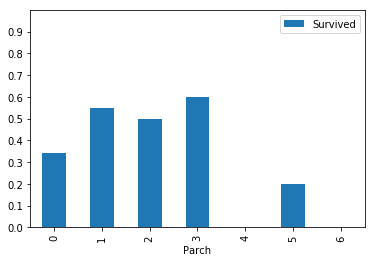

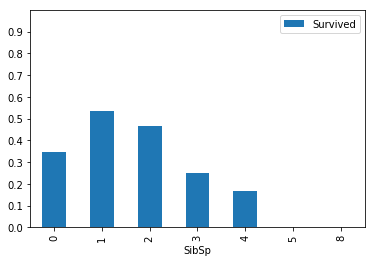

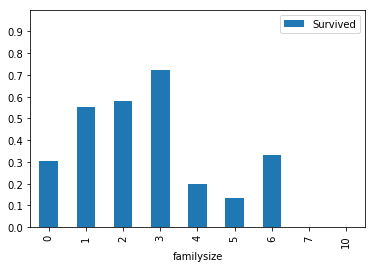

In [9]:
# Visualize pivot table for probability of survival based on number of relatives aboard
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index = col, values="Survived")
    pivot.plot.bar(ylim=(0,1), yticks = np.arange(0,1,.1))
    plt.show()

The above graphs show the probability of survival for various values of `SibSp` and `Parch`. Each distribution is right skewed, dropping off as values increase.

In examining the `familysize` graph, we observe that few of the passengers with no family members aboard survived, while likelihood of survival was substantially greater for those with more family members.

## Engineering New Features

Based on the previous findings, we can determine a new feature: a binary category showing whether or not a passenger was alone. Below, we create the function for engineering this feature and apply it to each dataset.

In [10]:
def solo_passenger(df):
    df["isalone"] = 0
    df["familysize"] = df[["SibSp", "Parch"]].sum(axis=1)
    df.loc[(df["familysize"] == 0), "isalone"] = 1
    df = df.drop("familysize", axis=1)
    return df

# Apply function to each dataset
train = solo_passenger(train)
holdout = solo_passenger(holdout)

## Selecting the Best-Performing Features

A crucial step in the machine learning workflow is feature selection. To automate this process, we can create a function using scikit Learn's `feature_selection.REFCV` class that will select best-performing features using recursive feature elimination.

Below, we create this function and apply it to the train dataset to identify the best features for prediction of the `Survived` column.

In [11]:
# Import packages
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # Select only numeric features
    df = df.select_dtypes(include = [np.number]).dropna(axis=1)
    
    # Drop unnecessary and target columns
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    # Instantiate random forest object
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    
    # Function returns printed list of the best features for rendering accurate model
    best_features = list(all_X.columns[selector.support_])
    print(best_features)
    
    return best_features

# Apply function to training dataset to select optimal features to use as predictors
train_best = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


In [12]:
train_best

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Young Adult',
 'Fare_categories_12-50',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'isalone']

## Selecting and Tuning Different Algorithms

Similar to the previous step, we can automate the process of hyperparameter optimization with a function that cycles through choices for various algorithm parameters and returns the combination with the best prediction accuracy score. Our three main model frameworks will be logistic regression, k-nearest neighbors, and random forest, meaning the function will return the best-performing candidate for each of these three model types.

The structure of the function involves a list of dictionaries. Each dictionary in the list contains a different model type, an instantiated estimator object, and a selection of hyperparameters for different attributes of that object. The function tests each combination of hyperparameters for each of the three model types, then outputs the three highest accuracy scores and hyperparameters that led to them.

In [13]:
# Import packages
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    
    # Dictionary of model types, objects, and parameter options
    model_dicts = [{
        "name": "LogisticRegression",
        "estimator": LogisticRegression(max_iter = 10000),
        "hyperparameters": 
            {"solver": ["newton-cg", "lbfgs", "liblinear"]}
        }, 
        {"name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters": {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]}
        }, 
        {"name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters": {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]}
        }
    ]
    
    # Run each model type and print the most accurate version
    for i in model_dicts:
        print(i["name"])
        print("-"*len(i["name"]))
        
        grid = GridSearchCV(i["estimator"],
                           param_grid = i["hyperparameters"],
                           cv = 10)
        grid.fit(all_X, all_y)
        i["best_params"] = grid.best_params_
        i["best_score"] = grid.best_score_
        i["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(i["best_score"]))
        print("Best Parameters: {}".format(i["best_params"]))
        
    return model_dicts


result = select_model(train, train_best)        

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}
KNeighborsClassifier
--------------------


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
RandomForestClassifier
----------------------
Best Score: 0.8406285072951739
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}


## Submitting to Kaggle

The end result of our hyperparameter and model optimization shows that the random forest algorithm is the most accurate, though its strength can be improved. If we prefer to add and re-engineer features in an effort to boost the accuracy score, we may do so and once more call the previous optimization function.

Else, we can create a function that will automatically save our best model so that it can be uploaded to Kaggle.

In [14]:
def save_submission_file(model, features, filename = "submission.csv"):
    holdout_predictions = model.predict(holdout[features])
    submission = pd.DataFrame({"PassengerID":holdout["PassengerId"], "Survived":holdout_predictions})
    submission.to_csv(filename, index=False)

In [15]:
save_submission_file(result[2]["best_model"], train_best)

## Conclusion

In this project, we stepped through an entire machine learning workflow to complete a Kaggle competition predicting whether Titanic passengers survived the shipwreck. Our best model was a random forest with ~84% prediction accuracy. This is a high mark, but there is still room for improvement. Our accuracy score can climb the Kaggle leaderboards with further feature creation and engineering or the addition of other model types from which to choose.